Вы получили основные навыки обработки данных, теперь пора испытать их на практике. Сейчас вам предстоит заняться задачей классификации.

Представлен датасет центра приюта животных, и вашей задачей будет обучить модель таким образом, чтобы  по определенным признакам была возможность максимально уверенно предсказать метки 'Adoption' и 'Transfer' (столбец “outcome_type”).

Здесь вы вольны делать что угодно. Я хочу видеть от вас:
1. Проверка наличия/обработка пропусков
2. Проверьте взаимосвязи между признаками
3. Попробуйте создать свои признаки
4. Удалите лишние
5. Обратите внимание на текстовые столбцы. Подумайте, что можно извлечь полезного оттуда
6. Использование профайлера вам поможет.
7. Не забывайте, что у вас есть PCA (Метод главных компонент). Он может пригодиться.

Вспомните о всем, что я говорил на предыдущих занятиях. Не все будет пригодится, но в жизни вам никто не будет говорить, что использовать :)

Хорошим классификатором для этой задачи будет "Случайный лес" (https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)

Понимать суть работы "леса" не обязательно на данном этапе, но качество предсказаний будет выше, чем с линейным классификатором. (если желаете, вот гайд https://adataanalyst.com/scikit-learn/linear-classification-method/)

Желаю успеха :)

In [128]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import datetime as dt
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

In [129]:
df = pd.read_csv('aac_shelter_outcomes.csv')
df.shape

(78256, 12)

In [130]:
df.head()

,age_upon_outcome,animal_id,animal_type,breed,color,date_of_birth,datetime,monthyear,name,outcome_subtype,outcome_type,sex_upon_outcome
0,2 weeks,A684346,Cat,Domestic Shorthair Mix,Orange Tabby,2014-07-07T00:00:00,2014-07-22T16:04:00,2014-07-22T16:04:00,NaN,Partner,Transfer,Intact Male
1,1 year,A666430,Dog,Beagle Mix,White/Brown,2012-11-06T00:00:00,2013-11-07T11:47:00,2013-11-07T11:47:00,Lucy,Partner,Transfer,Spayed Female
2,1 year,A675708,Dog,Pit Bull,Blue/White,2013-03-31T00:00:00,2014-06-03T14:20:00,2014-06-03T14:20:00,*Johnny,NaN,Adoption,Neutered Male
3,9 years,A680386,Dog,Miniature Schnauzer Mix,White,2005-06-02T00:00:00,2014-06-15T15:50:00,2014-06-15T15:50:00,Monday,Partner,Transfer,Neutered Male
4,5 months,A683115,Other,Bat Mix,Brown,2014-01-07T00:00:00,2014-07-07T14:04:00,2014-07-07T14:04:00,NaN,Rabies Risk,Euthanasia,Unknown


In [131]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78256 entries, 0 to 78255
Data columns (total 12 columns):
age_upon_outcome    78248 non-null object
animal_id           78256 non-null object
animal_type         78256 non-null object
breed               78256 non-null object
color               78256 non-null object
date_of_birth       78256 non-null object
datetime            78256 non-null object
monthyear           78256 non-null object
name                54370 non-null object
outcome_subtype     35963 non-null object
outcome_type        78244 non-null object
sex_upon_outcome    78254 non-null object
dtypes: object(12)
memory usage: 7.2+ MB


In [132]:
# эти два столбца дублируют друг друга. -удалим
df[ df['datetime']!=df['monthyear'] ].count()

age_upon_outcome    0
animal_id           0
animal_type         0
breed               0
color               0
date_of_birth       0
datetime            0
monthyear           0
name                0
outcome_subtype     0
outcome_type        0
sex_upon_outcome    0
dtype: int64

In [133]:
# Удалим столбцы  monthyear(дубль datetime), age_upon_outcome(его можно вычислить точнее с помощью dateofbirth и datetime),
# name(имя для животного не важно+ заполено частично), animal_id(id не влияет ни на что)
# также с помощью профайлера увидел что в outcome_subtype много пропущенных значений, это поле также стоит удалить

In [134]:
df = df.drop(columns=['monthyear','name','animal_id', 'age_upon_outcome','outcome_subtype'])
df.head()

,animal_type,breed,color,date_of_birth,datetime,outcome_type,sex_upon_outcome
0,Cat,Domestic Shorthair Mix,Orange Tabby,2014-07-07T00:00:00,2014-07-22T16:04:00,Transfer,Intact Male
1,Dog,Beagle Mix,White/Brown,2012-11-06T00:00:00,2013-11-07T11:47:00,Transfer,Spayed Female
2,Dog,Pit Bull,Blue/White,2013-03-31T00:00:00,2014-06-03T14:20:00,Adoption,Neutered Male
3,Dog,Miniature Schnauzer Mix,White,2005-06-02T00:00:00,2014-06-15T15:50:00,Transfer,Neutered Male
4,Other,Bat Mix,Brown,2014-01-07T00:00:00,2014-07-07T14:04:00,Euthanasia,Unknown


In [135]:
df['outcome_type'].unique()

array(['Transfer', 'Adoption', 'Euthanasia', 'Return to Owner', 'Died',
       'Disposal', 'Relocate', 'Missing', nan, 'Rto-Adopt'], dtype=object)

In [136]:
# удалим строки датасета где нет признаков adoption и transfer
df = df[ df['outcome_type'].isin(['Transfer', 'Adoption']) ]
df.shape

(56611, 7)

In [137]:
# создадим новую переменную, возраст животного в днях когда его забрали из приюта
# а после удалим переменную date_of_birth так как больше не понадобится
# и приведем поле datetime в числовую переменную, понятную программе при обучении
df['days_upon_outcome'] = (pd.to_datetime(df.datetime, format = '%Y-%m-%dT%H:%M:%S') - pd.to_datetime(df.date_of_birth, format = '%Y-%m-%dT%H:%M:%S')).dt.days
df = df.drop('date_of_birth', axis=1)
df['datetime'] = pd.to_datetime(df.datetime).map(dt.datetime.toordinal)
df.head(5)

,animal_type,breed,color,datetime,outcome_type,sex_upon_outcome,days_upon_outcome
0,Cat,Domestic Shorthair Mix,Orange Tabby,735436,Transfer,Intact Male,15
1,Dog,Beagle Mix,White/Brown,735179,Transfer,Spayed Female,366
2,Dog,Pit Bull,Blue/White,735387,Adoption,Neutered Male,429
3,Dog,Miniature Schnauzer Mix,White,735399,Transfer,Neutered Male,3300
5,Dog,Leonberger Mix,Brown/White,735148,Transfer,Intact Male,126


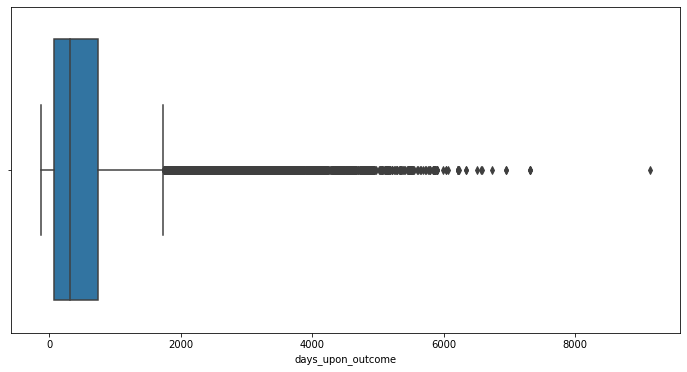

In [138]:
plt.figure(figsize=(12,6))
sns.boxplot(x=df['days_upon_outcome']) 

In [139]:
df['days_upon_outcome'].describe()

count    56611.000000
mean       632.756019
std        907.937047
min       -123.000000
25%         78.000000
50%        312.000000
75%        742.000000
max       9137.000000
Name: days_upon_outcome, dtype: float64

In [140]:
#из анализа переменной видно что есть отрицаетльные значения, их удалим так как это ошибка
# также удалим выбросы - значения больше 5 тыс. дней

In [141]:
df = df[ (df['days_upon_outcome']>=0) & (df['days_upon_outcome']<=5000) ]
df.days_upon_outcome.describe()

count    56389.000000
mean       614.084644
std        857.029502
min          0.000000
25%         78.000000
50%        311.000000
75%        741.000000
max       4969.000000
Name: days_upon_outcome, dtype: float64

In [142]:
# добавим новую переменную is_adopted, и удалим outcome_type
df['is_adopted'] = [ 1 if x=='Adoption' else 0 for x in df.outcome_type ]
df = df.drop('outcome_type', axis=1)
df.head()

,animal_type,breed,color,datetime,sex_upon_outcome,days_upon_outcome,is_adopted
0,Cat,Domestic Shorthair Mix,Orange Tabby,735436,Intact Male,15,0
1,Dog,Beagle Mix,White/Brown,735179,Spayed Female,366,0
2,Dog,Pit Bull,Blue/White,735387,Neutered Male,429,1
3,Dog,Miniature Schnauzer Mix,White,735399,Neutered Male,3300,0
5,Dog,Leonberger Mix,Brown/White,735148,Intact Male,126,0


In [143]:
# переходим к анализу переменной sex_upon_outcome
# Считаю что стоит удалить значения где неизвестен пол, часто для хозяев пол животного важен 
df.sex_upon_outcome.value_counts()

Neutered Male    20639
Spayed Female    19857
Intact Female     6857
Intact Male       6276
Unknown           2760
Name: sex_upon_outcome, dtype: int64

In [144]:
df = df[ df['sex_upon_outcome']!='Unknown' ]

In [145]:
# из переменной sex_upon_outcome создадим три - is_male, is_female, is_intact(не кастрирован)
df['is_male'] = [ 1 if 'Male' in x else 0 for x in df.sex_upon_outcome ]
df['is_female'] = [ 1 if 'Female' in x else 0 for x in df.sex_upon_outcome ]
df['is_intact'] = [ 1 if 'Intact' in x else 0 for x in df.sex_upon_outcome ]
df = df.drop('sex_upon_outcome', axis=1)
df.head()

,animal_type,breed,color,datetime,days_upon_outcome,is_adopted,is_male,is_female,is_intact
0,Cat,Domestic Shorthair Mix,Orange Tabby,735436,15,0,1,0,1
1,Dog,Beagle Mix,White/Brown,735179,366,0,0,1,0
2,Dog,Pit Bull,Blue/White,735387,429,1,1,0,0
3,Dog,Miniature Schnauzer Mix,White,735399,3300,0,1,0,0
5,Dog,Leonberger Mix,Brown/White,735148,126,0,1,0,1


In [146]:
# переходим к анализу переменной breed
df['breed'].value_counts()

Domestic Shorthair Mix                  18788
Pit Bull Mix                             3493
Chihuahua Shorthair Mix                  3359
Labrador Retriever Mix                   3214
Domestic Medium Hair Mix                 1896
                                        ...  
Catahoula/Jack Russell Terrier              1
Pit Bull/Queensland Heeler                  1
Basset Hound/Dachshund                      1
Chihuahua Longhair/Italian Greyhound        1
Beagle/Chihuahua Longhair                   1
Name: breed, Length: 1762, dtype: int64

In [147]:
df.breed.str.contains('Mix').value_counts()

True     46102
False     7527
Name: breed, dtype: int64

In [148]:
# создадим переменную - чистая порода или нет
df['is_mix'] = [ 1 if 'mix' in x else 0 for x in df.breed.str.lower() ]
df = df.drop('breed', axis=1)
df.head()

,animal_type,color,datetime,days_upon_outcome,is_adopted,is_male,is_female,is_intact,is_mix
0,Cat,Orange Tabby,735436,15,0,1,0,1,1
1,Dog,White/Brown,735179,366,0,0,1,0,1
2,Dog,Blue/White,735387,429,1,1,0,0,0
3,Dog,White,735399,3300,0,1,0,0,1
5,Dog,Brown/White,735148,126,0,1,0,1,1


In [149]:
#рассмотрим переменную animal_type
df.animal_type.unique()

array(['Cat', 'Dog', 'Other', 'Bird', 'Livestock'], dtype=object)

In [150]:
# создадим для каждого вида животного свой флаг
df['is_cat'] = [ 1 if x=='Cat' else 0 for x in df.animal_type]
df['is_dog'] = [ 1 if x=='Dog' else 0 for x in df.animal_type]
df['is_other'] = [ 1 if x=='Other' else 0 for x in df.animal_type]
df['is_bird'] = [ 1 if x=='Bird' else 0 for x in df.animal_type]
df['is_livestock'] = [ 1 if x=='Livestock' else 0 for x in df.animal_type]
df = df.drop('animal_type', axis=1)
df.head()

,color,datetime,days_upon_outcome,is_adopted,is_male,is_female,is_intact,is_mix,is_cat,is_dog,is_other,is_bird,is_livestock
0,Orange Tabby,735436,15,0,1,0,1,1,1,0,0,0,0
1,White/Brown,735179,366,0,0,1,0,1,0,1,0,0,0
2,Blue/White,735387,429,1,1,0,0,0,0,1,0,0,0
3,White,735399,3300,0,1,0,0,1,0,1,0,0,0
5,Brown/White,735148,126,0,1,0,1,1,0,1,0,0,0


In [ ]:
#модель 

In [151]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53629 entries, 0 to 78255
Data columns (total 13 columns):
color                53629 non-null object
datetime             53629 non-null int64
days_upon_outcome    53629 non-null int64
is_adopted           53629 non-null int64
is_male              53629 non-null int64
is_female            53629 non-null int64
is_intact            53629 non-null int64
is_mix               53629 non-null int64
is_cat               53629 non-null int64
is_dog               53629 non-null int64
is_other             53629 non-null int64
is_bird              53629 non-null int64
is_livestock         53629 non-null int64
dtypes: int64(12), object(1)
memory usage: 5.7+ MB


In [156]:
X = df.drop(['is_adopted', 'color'], axis=1)    # также удалим столбец цвет животного
Y = df['is_adopted']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3)

In [157]:
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((37540, 11), (16089, 11), (37540,), (16089,))

In [158]:
clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train, Y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [159]:
clf.score(X_test, Y_test)

0.8121076511902542

Точность модели около 80%

In [ ]:
# профайлер

In [160]:
df.drop_duplicates().shape

(51410, 13)

In [ ]:
df.profile_report()